### Inference

### 모델 로드

In [1]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
# we are going to do whole inference, so no resizing of the image
processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# 모델의 헤드 클래스 수를 변경
model.config.num_labels = 12  # fine-tuning 데이터셋의 클래스 수에 맞게 변경
model.decode_head.classifier = torch.nn.Conv2d(768, model.config.num_labels, kernel_size=1)  # 768은 B3의 내부 차원 수
model.load_state_dict(torch.load("C:/Users/USER/Desktop/용용/딥러닝부트캠프/iamge_project2/saved_models/best_model.pth", map_location=device))


# model.to(device)

c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [2]:
model.to(device)
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

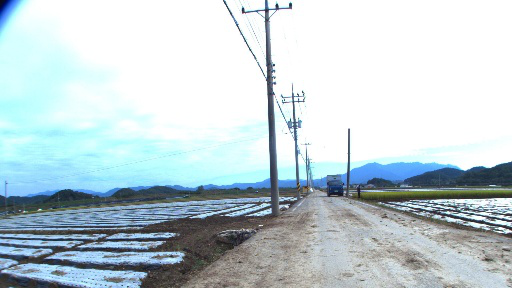

In [105]:
from PIL import Image

# load image + ground truth map
image_path = "C:/Users/USER/Desktop/resized_valid_image/NIA_AgricultureAD_paddy_RGB_bottom_Gyeongsangnamdo_2110151007_day_sunny_003341.jpg"
image = Image.open(image_path)

image
     

### 이미지 전처리

In [107]:
from PIL import Image
import torchvision.transforms as T
import torch

# 전처리 파이프라인 설정
def preprocess_image(image_path, transforms):
    # 이미지 파일을 열고 RGB로 변환
    image = Image.open(image_path).convert('RGB')

    # 전달된 전처리 변환을 이미지에 적용
    if transforms:
        image = transforms(image)
    
    return image

# 이미지 경로
image_path = "C:/Users/USER/Desktop/resized_valid_image/NIA_AgricultureAD_paddy_RGB_bottom_Gyeongsangnamdo_2110151007_day_sunny_003341.jpg"
image = Image.open(image_path)

# 전처리 변환 (훈련과 동일)
inference_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 이미지 전처리
processed_image = preprocess_image(image_path, inference_transforms)

# 차원 조정 (batch_size, C, H, W)
processed_image = processed_image.unsqueeze(0)  # 이는 모델에 입력하기 위해 필요한 배치 차원을 추가합니다.

processed_image.shape
processed_image= processed_image.to(device)


In [108]:
import torch

with torch.no_grad():
  outputs = model(processed_image)
  logits = outputs.logits

In [109]:
print(logits.shape)

torch.Size([1, 12, 72, 128])


In [115]:
import torch.nn.functional as F
upsampled_logits = F.interpolate(logits, size=(288 ,512), mode="bilinear", align_corners=False)
# 소프트맥스를 적용하여 픽셀별 클래스 확률을 계산
probabilities = F.softmax(upsampled_logits, dim=1)

# 각 픽셀에서 최대 확률과 해당 인덱스를 계산
max_probs, predicted_classes = torch.max(probabilities, dim=1)

# 임계값 설정 (예: 0.5)
threshold = 0.5

# 임계값 미만인 픽셀을 배경으로 설정
predicted_classes[max_probs < threshold] = 0


# Tensor를 Numpy 배열로 변환
mask_np = predicted_classes.cpu().numpy()

In [116]:
mask_np.shape

(1, 288, 512)

In [117]:
import numpy as np
image = np.array(image)
image.shape

(288, 512, 3)

### 시각화

In [122]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation(image, mask, alpha=1):
    """
    이미지와 세그멘테이션 마스크를 시각화합니다.
    :param image: PIL 이미지 또는 NumPy 배열
    :param mask: 세그멘테이션 마스크 (numpy 배열)
    :param alpha: 마스크의 투명도
    """
    if not isinstance(image, np.ndarray):
        image = np.array(image)
        
    mask = mask.squeeze()
    # 12개 클래스에 대한 색상 매핑 정의
    colors = np.array([
        [0, 0, 0],        # 배경
        [128, 64, 128],   # 클래스 1 - common_road
        [244, 35, 232],   # 클래스 2 - common_tree
        [70, 70, 70],     # 클래스 3 - field_corps
        [102, 102, 156],  # 클래스 4 - field_furrow
        [190, 153, 153],  # 클래스 5 - field_levee
        [153, 153, 153],  # 클래스 6 - orchard_road
        [250, 170, 30],   # 클래스 7 - orchard_tree
        [220, 220, 0],    # 클래스 8 - paddy_after_driving
        [107, 142, 35],   # 클래스 9 - paddy_before_driving
        [152, 251, 152],  # 클래스 10 - paddy_edge
        [70, 130, 180],   # 클래스 11 - paddy_rice
        [220, 20, 60]     # 클래스 12 - paddy_water
    ], dtype=np.uint8)

    colored_mask = colors[mask]
    combined = image.astype(np.float32) * (1 - alpha) + colored_mask.astype(np.float32) * alpha
    combined = combined.clip(0, 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(combined)
    plt.title('Segmentation Overlay')
    plt.axis('off')

    plt.show()

# 이미지와 예측된 마스크 데이터를 이 함수에 전달하여 시각화
# image는 PIL 이미지, predicted_classes는 위 코드에서 계산된 예측 클래스 numpy 배열


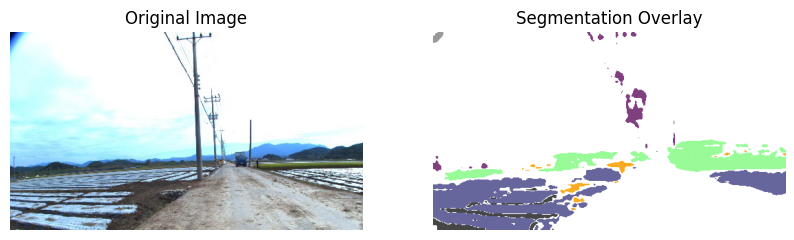

In [121]:
visualize_segmentation(image, mask_np)

### ground truth

In [104]:
import json
import numpy as np
from skimage.draw import polygon2mask

# 이미지 크기
height = 288
width = 512

# 빈 마스크 생성
color_mask = np.zeros((height, width, 3), dtype=np.uint8)

label_colors = {
    "field_levee": [255, 0, 0],  # 빨간색
    "field_road": [0, 255, 0],   # 초록색
    "field_tree": [0, 0, 255]    # 파란색
    # 추가 레이블과 색상 매핑 필요
}

with open("C:/Users/USER/Desktop/resized_valid_annotations/NIA_AgricultureAD_paddy_RGB_middle_Gyeongsangnamdo_2110061032_day_sunny_002084.json", 'r') as f:
    data= json.load(f)

# 객체 정보에서 폴리곤 좌표 추출 및 마스크에 적용
for obj in data['objects']:
    if obj['type'] == 'polygon':
        positions = np.array(obj['position'])
        xs = positions[::2]
        ys = positions[1::2]

        mask = polygon2mask((height, width), np.column_stack((ys, xs)))
        color = label_colors.get(obj['label'], [255, 255, 255])  # 기본 색상은 흰색
        color_mask[rr, cc] = color


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 0 and the array at index 1 has size 1

### 테스트 데이터 셋 생성

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import cv2
import numpy as np
from PIL import Image

# 모델 및 feature extractor 로드
MODEL_CHECKPOINT = 'nvidia/mit-b2'
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_CHECKPOINT, num_labels=12)
feature_extractor = SegformerFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 데이터 증강 파이프라인 정의
val_augmentations = A.Compose([
    A.OneOf([
        A.RandomRain(p=1.0),
        A.RandomSnow(p=1.0),
        A.RandomFog(p=1.0),
    ], p=1.0),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# 검증 데이터셋에서 증강 데이터 생성
class AugmentedValidationDataset(Dataset):
    def __init__(self, val_dataset, augmentations):
        self.val_dataset = val_dataset
        self.augmentations = augmentations

    def __len__(self):
        return len(self.val_dataset)

    def __getitem__(self, idx):
        image, mask = self.val_dataset[idx]
        augmented = self.augmentations(image=np.array(image))
        image = augmented['image']
        return image, mask

# 원본 검증 데이터셋 로드
val_dataset = CustomDataset("C:/Users/USER/Desktop/resized_valid_image", "C:/Users/USER/Desktop/resized_valid_annotations", transforms=None)

# 증강 검증 데이터셋 생성
augmented_val_dataset = AugmentedValidationDataset(val_dataset, val_augmentations)

# DataLoader 설정
augmented_val_loader = DataLoader(augmented_val_dataset, batch_size=1, shuffle=False, num_workers=4)

# 각 클래스 ID를 컬러로 변환하는 딕셔너리 필요
id2color = {
    0: [0, 0, 0],      # common_road
    1: [0, 255, 0],    # common_tree
    2: [255, 255, 0],  # field_corps
    3: [128, 128, 128],# field_furrow
    4: [0, 128, 0],    # field_levee
    5: [0, 0, 255],    # orchard_road
    6: [128, 0, 128],  # orchard_tree
    7: [255, 0, 0],    # paddy_after_driving
    8: [255, 192, 203],# paddy_before_driving
    9: [64, 64, 64],   # paddy_edge
    10: [128, 128, 0], # paddy_rice
    11: [0, 255, 255]  # paddy_water
}

# 추론 함수
def predict(image):
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        upsampled_logits = torch.nn.functional.interpolate(logits, size=image.size[::-1], mode='bilinear', align_corners=False)
        pred = upsampled_logits.argmax(dim=1).cpu().numpy()[0]
    return pred

# 증강된 검증 데이터에 대한 추론 수행
for idx, (image, mask) in enumerate(augmented_val_loader):
    image = image.permute(0, 2, 3, 1).squeeze(0).numpy()  # 채널 순서 변경 및 배치 차원 제거
    image = (image * 255).astype(np.uint8)
    image_pil = Image.fromarray(image)

    prediction = predict(image_pil)

    # 예측된 마스크를 컬러로 변환
    mask_colored = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
    for class_id, color in id2color.items():
        mask_colored[prediction == class_id] = color

    # 원본 이미지와 예측된 마스크를 결합
    overlay = cv2.addWeighted(image, 0.5, mask_colored, 0.5, 0)

    # 결과 출력
    cv2.imshow('Augmented Image', image)
    cv2.imshow('Segmentation Overlay', overlay)
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
